<h1>Preliminary exploratory data analysis: </h1>

First, the unprocessed data is imported from github to the notebook as information regarding smoking is not included in the provided processed dataset. After the raw data is imported, due to poor formatting of the data such as a single observation spaning multiple rows, the data regarding the number of years and average number of cigarettes of each patient is extracted. This data is further processed to determine whether a patient has (1) or has never (0) smoked, which is recorded as "smoker".

In [94]:
library(tidyverse)
library(repr)
library(readxl)
library(caret)
library(ggplot2)
options(repr.matrix.max.rows = 6)

In [95]:
#Importing the raw cleveland data from github, messy and unformatted with alot of errors
url <- "https://raw.githubusercontent.com/oskarjychen/dsci-100-group-1-project/f633cb6fce197444f4e13db28ad9275e935dea50/data/cleveland.data"
heart_disease_raw <- read_delim(url, col_names = FALSE, delim = " ")

#As one observation spans many rows, cycling rows and taking values which are pretaining to smoking
smoking_raw <- heart_disease_raw[seq(2, nrow(heart_disease_raw), 10),] |>
  rename("chol" = X5) |>
  na.omit()

#From the smoking values taken, determine if the person has smoked before or not, (1 true, 0 false)
smoking_df <- smoking_raw |>
  separate(col = X7, into = c("cigs", "years"), sep = " ", convert = TRUE, fill = "right", extra = "drop") |>
  mutate(smoker = ifelse(cigs == 0 & years == 0, 0, 1)) |>
  select(chol, smoker)

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 2982 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: " "
chr (1): X7
dbl (6): X1, X2, X3, X4, X5, X6

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Secondly, the processed data is imported from github to the notebook. This data set includes the rest of the meaningful data that our project will be analyzing, namely resting blood pressure (trestbps), Cholesterol (chol), and degree of heart healthiness (num) ranked from 0 - 4, with 0 being healthy and 4 being unhealthy. These data are chosen as they are directly related to both smoking and heart health while also being interconnected with one another. The data is further seperated into two subsets, one for smokers and one for non smokers, so that we may compare the 2 contrasting prediction models to determin the effects of smoking later in the project.

In [96]:
#Importing the processed cleveland data from github which has better formatted and accessible information
url = "https://raw.githubusercontent.com/oskarjychen/dsci-100-group-1-project/f633cb6fce197444f4e13db28ad9275e935dea50/data/processed.cleveland.data"
heart_disease <- read_csv(url, col_names = FALSE) |>
    select(X4, X5, X14) |>
    rename(trestbps = X4, 
           chol = X5, 
           num = X14) 

#Creating the base data set with all variables by merging the smoker table to the selected columns
merged_heart_disease <- merge(heart_disease, smoking_df, all = TRUE)[order(heart_disease$chol),] |>
na.omit()

#Creating 2 subsets from the base data set based on smoking vs non smoking
non_smoker <- merged_heart_disease |>
  filter(smoker == 0)

smoker <- merged_heart_disease |>
  filter(smoker == 1)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Thirdly, I create training data and test data with a ratio of 70% / 30%. The training data is summarized in a table which details the means of variables as well as the max, min, median, and sd of each variable. Num is excluded from most numerical average calcuations as it is only 0 - 4 and consists only of discrete values, thus not meaningful.

In [101]:
#Creating training data
set.seed(1)

train_indices_non_smoker <- createDataPartition(non_smoker$num, p = 0.7, list = FALSE)
train_data_non_smoker <- non_smoker[train_indices_non_smoker, ]
test_data_non_smoker <- non_smoker[-train_indices_non_smoker, ]

train_indices_smoker <- createDataPartition(smoker$num, p = 0.7, list = FALSE)
train_data_smoker <- smoker[train_indices_smoker, ]
test_data_smoker <- smoker[-train_indices_smoker, ]

# Let it be shown here that, depite numerous pleadings from the rest of the group, that one group member refuses to use code taught in lecture material.
# This note here is to show that the rest of the group member are unfamiliar with createDataPartition, doing the data splitting in this way prohibits 
# the learning of students who only have experience with R through this class. Below is how it would be done using class material
# non_smoker_split <- initial_split(non_smoker, prop = 0.7, strata = num)
# non_smoker_train <- training(non_smoker_split)
# non_smoker_test <- testing(non_smoker_split) 
# smoker_split <- initial_split(smoker, prop = 0.7, strata = num)
# smoker_train <- training(smoker_split)
# smoker_test <- testing(smoker_split) 
# or
# heart_disease_split  <- initial_split(merged_heart_disease, prop = 0.7, strata = num)
# heart_diseaser_train <- training(heart_disease_split)
# heart_diseaser_test <- testing(heart_disease_split) 


#Creating training data summary tables
train_data_summary <- merged_heart_disease %>%
  group_by(smoker) %>%
  summarize(
    observations = n(),
    trestbps_mean = mean(trestbps, na.rm = TRUE),
    chol_mean = mean(chol, na.rm = TRUE),
    num_missing_rows = sum(is.na(.)),
    min_chol = min(chol, na.rm = TRUE),
    max_chol = max(chol, na.rm = TRUE),
    median_chol = median(chol, na.rm = TRUE),
    sd_chol = sd(chol, na.rm = TRUE)
  )

train_data_summary

smoker,observations,trestbps_mean,chol_mean,num_missing_rows,min_chol,max_chol,median_chol,sd_chol
<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
0,104,127.8269,204.3846,0,126,230,204,20.24093
1,190,127.7105,205.8105,0,149,230,207,15.91265


Next, the distrubtion of each variable classified by smoking vs non-smoking are visualized in density graphs.

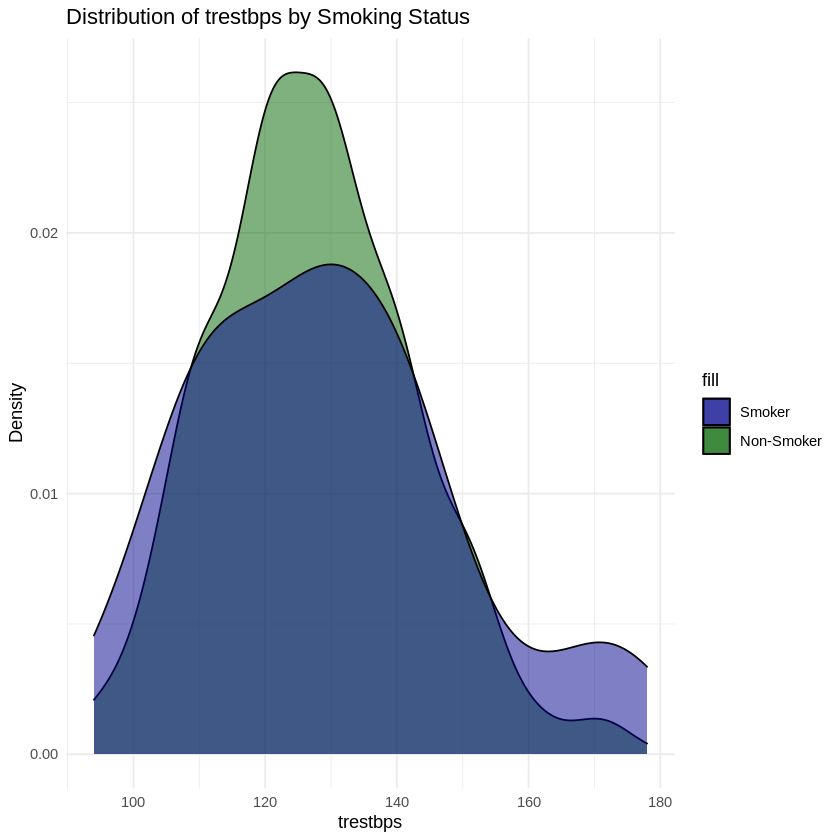

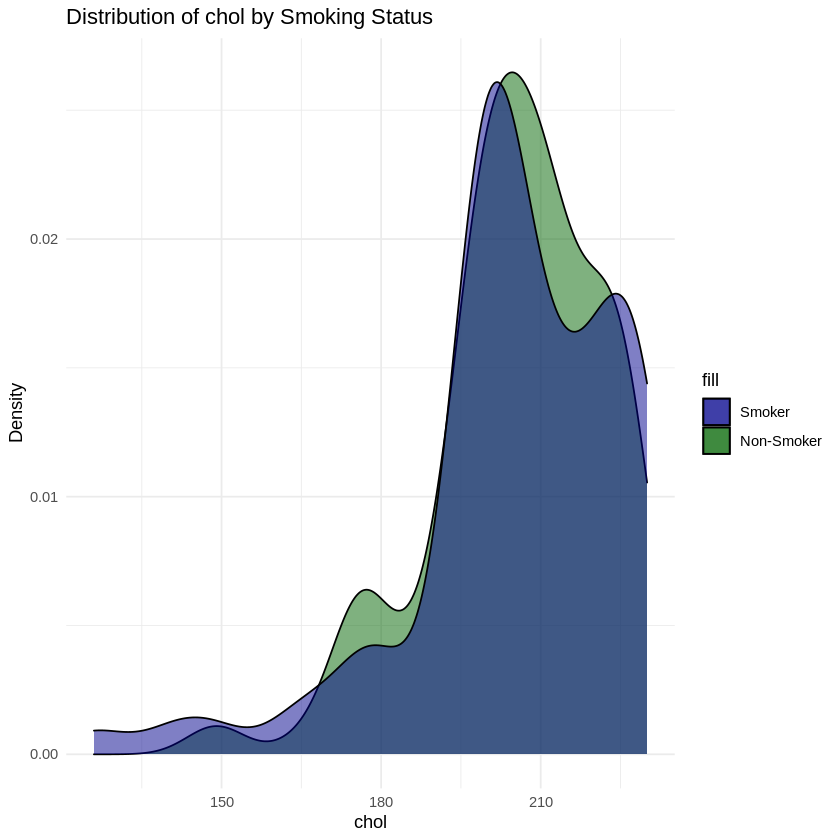

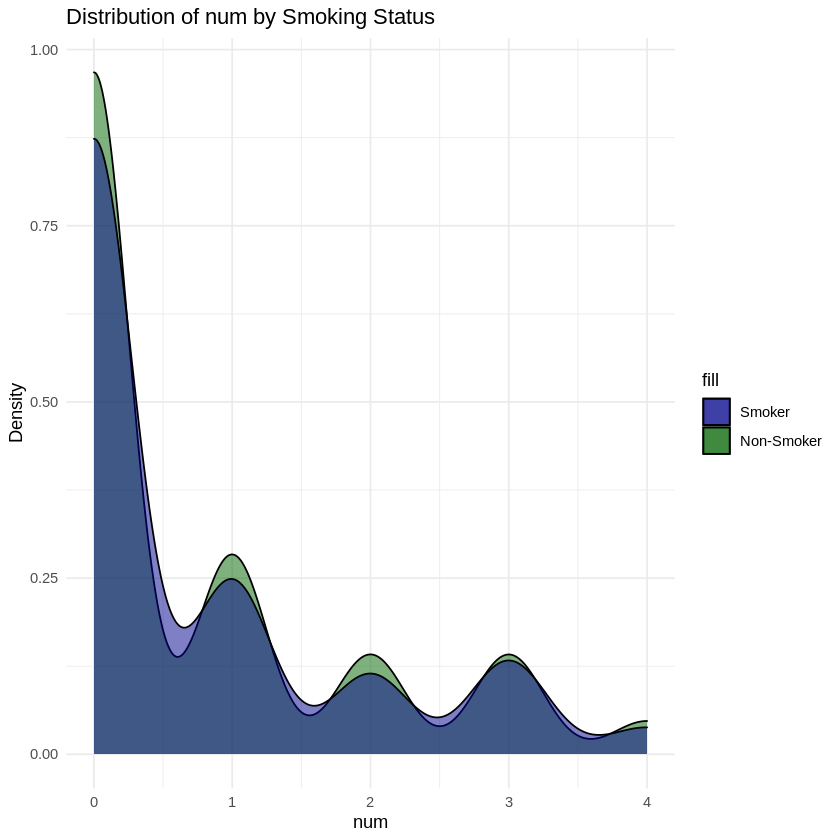

In [98]:
# Distribution of trestbps variable
ggplot() +
  geom_density(data = train_data_smoker, aes(x = trestbps, fill = "Smoker"), alpha = 0.5) +
  geom_density(data = train_data_non_smoker, aes(x = trestbps, fill = "Non-Smoker"), alpha = 0.5) +
  labs(x = "trestbps", y = "Density", title = "Distribution of trestbps by Smoking Status") +
  scale_fill_manual(values = c("darkblue", "darkgreen"), labels = c("Smoker", "Non-Smoker")) +
  theme_minimal()

# Distribution of chol variable
ggplot() +
  geom_density(data = train_data_smoker, aes(x = chol, fill = "Smoker"), alpha = 0.5) +
  geom_density(data = train_data_non_smoker, aes(x = chol, fill = "Non-Smoker"), alpha = 0.5) +
  labs(x = "chol", y = "Density", title = "Distribution of chol by Smoking Status") +
  scale_fill_manual(values = c("darkblue", "darkgreen"), labels = c("Smoker", "Non-Smoker")) +
  theme_minimal()

# Distribution of num(degree of healthiness from 0, healthy, to 4, unhealthy)
ggplot() +
  geom_density(data = train_data_smoker, aes(x = num, fill = "Smoker"), alpha = 0.5) +
  geom_density(data = train_data_non_smoker, aes(x = num, fill = "Non-Smoker"), alpha = 0.5) +
  labs(x = "num", y = "Density", title = "Distribution of num by Smoking Status") +
  scale_fill_manual(values = c("darkblue", "darkgreen"), labels = c("Smoker", "Non-Smoker")) +
  theme_minimal()


Lastly,Cholesterol vs Resting Blood pressure, categorized by health level from 0 to 4, are visualized in scatterplots based on smoking vs non smoking. By contrasting the two graphs, one can already make a reasonable hypothesis as to the effects of smoking on ones heart health.

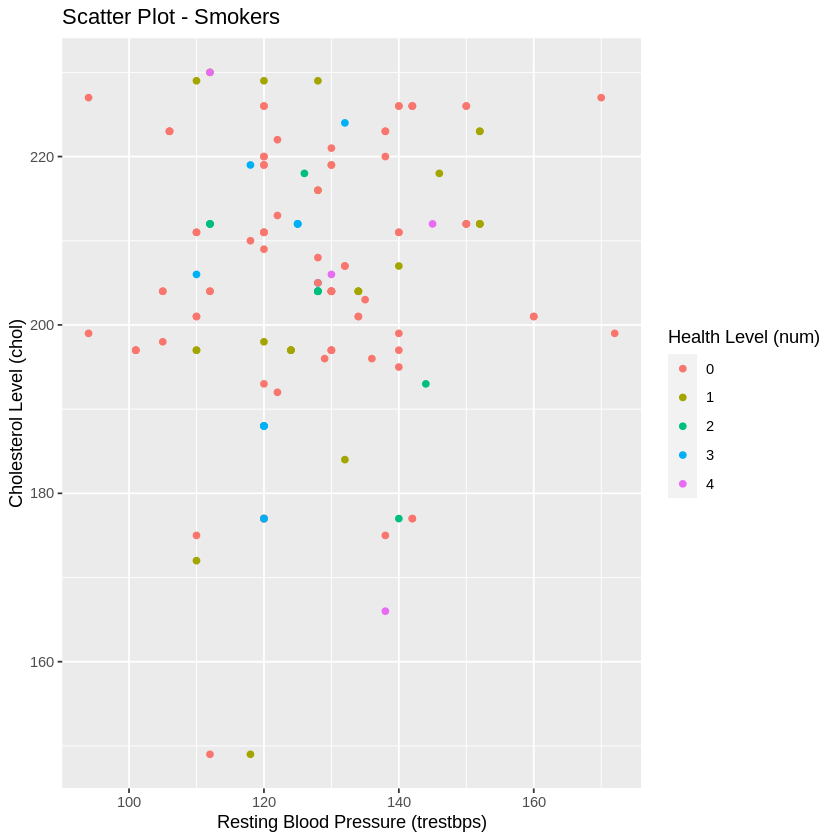

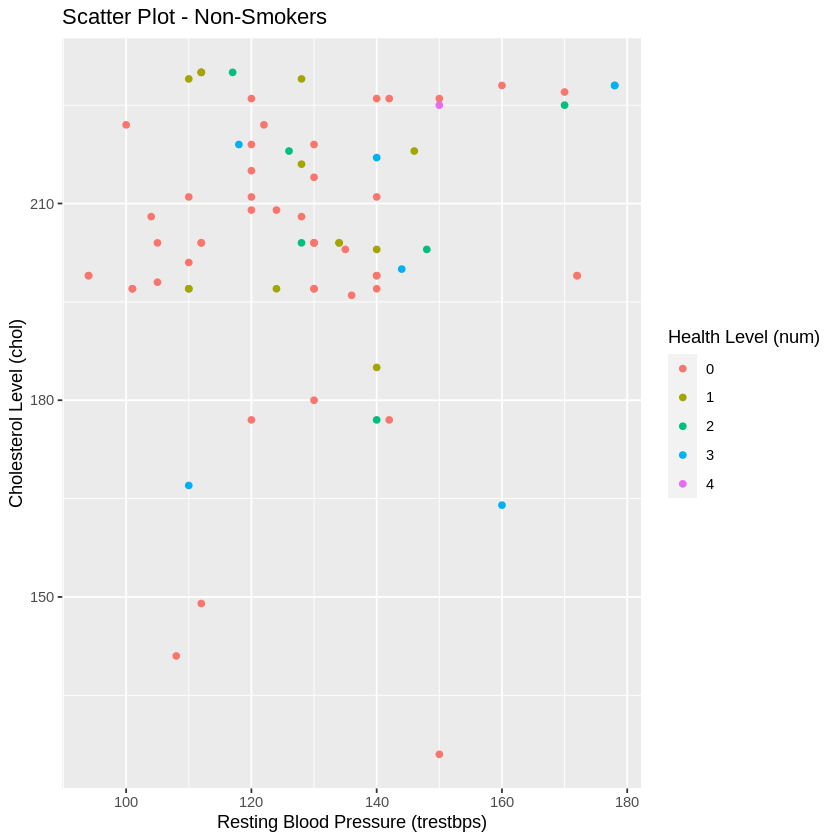

In [102]:
# Scatter plot for smokers
ggplot(train_data_smoker, aes(x = trestbps, y = chol, color = factor(num))) +
  geom_point() +
  labs(title = "Scatter Plot - Smokers",
       x = "Resting Blood Pressure (trestbps)",
       y = "Cholesterol Level (chol)",
       color = "Heart Health Level (num)")

# Scatter plot for non-smokers
ggplot(train_data_non_smoker, aes(x = trestbps, y = chol, color = factor(num))) +
  geom_point() +
  labs(title = "Scatter Plot - Non-Smokers",
       x = "Resting Blood Pressure (trestbps)",
       y = "Cholesterol Level (chol)",
       color = "Heart Health Level (num)")